In [1]:
import geopandas as gpd
import rasterio
from pathlib import Path
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np

In [2]:
out = Path('out')

In [3]:
df = gpd.read_file(out / 'metadata.geojson')
df.head()

,opera_id,start_time,polarization,url,track_number,local_path,geometry
0,OPERA_L2_RTC-S1_T078-165486-IW2_20231105T00482...,2023-11-05 00:48:29+00:00,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,78,out/78/OPERA_L2_RTC-S1_T078-165486-IW2_2023110...,"POLYGON ((-99.92892 16.73507, -99.06057 16.896..."
1,OPERA_L2_RTC-S1_T041-086893-IW1_20231102T12352...,2023-11-02 12:35:27+00:00,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,41,out/41/OPERA_L2_RTC-S1_T041-086893-IW1_2023110...,"POLYGON ((-99.50360 16.87667, -100.30172 17.02..."
2,OPERA_L2_RTC-S1_T078-165486-IW2_20231024T00482...,2023-10-24 00:48:29+00:00,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,78,out/78/OPERA_L2_RTC-S1_T078-165486-IW2_2023102...,"POLYGON ((-99.92881 16.73528, -99.88313 16.743..."
3,OPERA_L2_RTC-S1_T041-086893-IW1_20231021T12352...,2023-10-21 12:35:27+00:00,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,41,out/41/OPERA_L2_RTC-S1_T041-086893-IW1_2023102...,"POLYGON ((-99.50539 16.87704, -99.54850 16.885..."
4,OPERA_L2_RTC-S1_T078-165486-IW2_20231012T00482...,2023-10-12 00:48:28+00:00,VH,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,78,out/78/OPERA_L2_RTC-S1_T078-165486-IW2_2023101...,"POLYGON ((-99.92546 16.73504, -99.87977 16.743..."


In [4]:
track_number = 78 # 41 or 78

df_by_track = df[df.track_number == track_number].reset_index(drop=True)
df_by_track = df_by_track.sort_values(by='opera_id')

In [5]:
def open_one(path):
    with rasterio.open(path) as ds:
        p = ds.profile
        X = ds.read(1)
    m = 0 # np.nanpercentile(X, 1)
    M = 1 # np.nanpercentile(X, 99)
    X = np.clip(X, m, M)
    return X, p

arrays_vv, profiles_vv = zip(*list(map(open_one, df_by_track[df_by_track.polarization == 'VV'].local_path)))
arrays_vh, profiles_vh = zip(*list(map(open_one, df_by_track[df_by_track.polarization == 'VH'].local_path)))

factor = 5
arrays_ra = [np.clip(vh / vv, 1./factor, factor) / factor for (vv, vh) in zip(arrays_vv, arrays_vh)]

mask = np.isnan(arrays_vh[0])

Ref: https://ceos.org/ard/files/Laymans_SAR_Interpretation_Guide_3.0.pdf

/Users/cmarshak/mambaforge/envs/opera-change/lib/python3.12/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


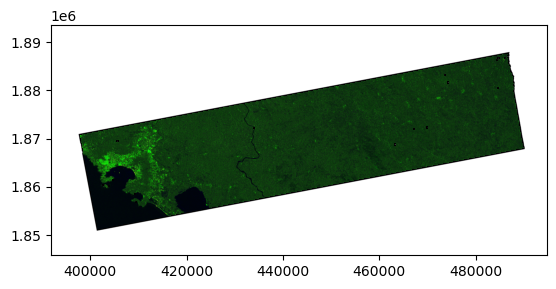

<Axes: >

In [6]:
ind = 0

rgb = np.stack([arrays_vh[ind],
                arrays_vv[ind],
                arrays_ra[ind],
                1-mask], axis=0)
show(rgb, transform=profiles_vv[0]['transform'])

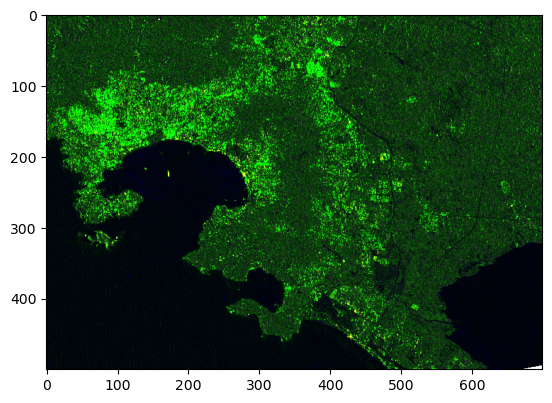

In [7]:
sy = np.s_[800:1300]
sx = np.s_[300:1000]
plt.imshow(rgb.transpose([1, 2, 0])[sy, sx, :])

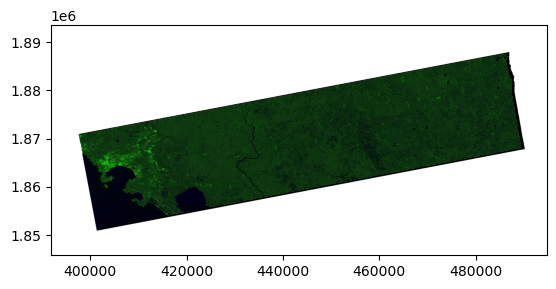

<Axes: >

In [8]:
ind = -2

rgb = np.stack([arrays_vh[ind],
                arrays_vv[ind],
                arrays_ra[ind],
                1-mask], axis=0)
show(rgb, transform=profiles_vv[0]['transform'])

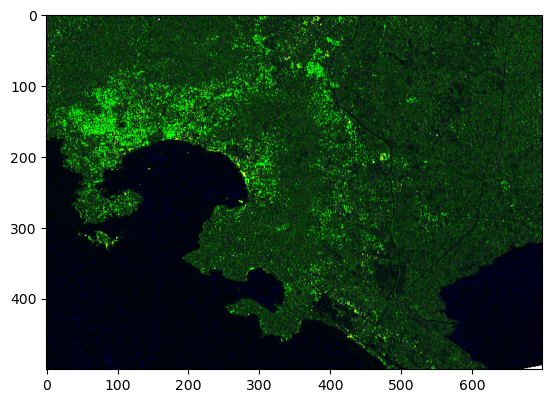

In [9]:
sy = np.s_[800:1300]
sx = np.s_[300:1000]
plt.imshow(rgb.transpose([1, 2, 0])[sy, sx, :])